Let's say that we want to predict the cost to ship a package based on its properties. You can think of each package as a point in six-dimensional space - 5 dimensions for our features and 1 for our target.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

packages = pd.read_csv('packages.csv')
packages.head(5)

c:\Users\marha\.conda\envs\ml\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,Shipping Cost ($),Length (in),Width (in),Height (in),Weight (lb),Distance (mi)
0,24,36,32,9,18,1079
1,38,41,31,12,18,1797
2,38,34,34,15,24,1722
3,20,32,22,8,8,461
4,24,37,24,14,19,491


The first four features in this dataset all relate to package size, so we might expect them to be strongly related. 

PCA does not use the standard correlation matrix, which is conveniently scaled between -1 and 1. Instead, it uses the covariance matrix, which is scaled in square units of the original variables. This makes PCA very sensitive to the scale of the variables. 

Let's normalize our variables to mean = 0 & SD = 1, which will make our covariance matrix equal the correlation matrix.

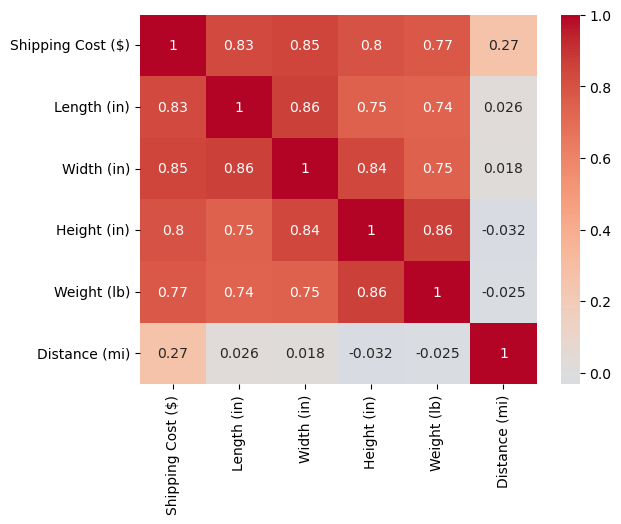

In [3]:
packages_scaled = (packages - packages.mean())/packages.std() # Standard scaler formula
sns.heatmap(packages_scaled.cov(),
           annot=True,
           fmt='0.2g',
           center=0,
           cmap='coolwarm');

The covariance matrix preserves the information about the spread of our dataset. We now want to explain that spread, one linear transformation (one eigenvector) at a time. 

Since the features capturing size are strongly correlated, we might expect to be able to reduce our feature dimensions down to two without losing much information (i.e. variance in our features).

We will use an eigendecomposition of the covariance matrix to create a new set of dimensions. We can then decide how many of these dimensions to keep based on how much variance is captured by each dimension.

Here, we show you how to do this using the NumPy .eig() function, but we will learn how to do PCA more easily in sklearn for true implementation.

In [4]:
X_packages_scaled = packages_scaled.drop('Shipping Cost ($)', axis=1)

cov_mat = X_packages_scaled.cov().values
eigvals, eigvecs = np.linalg.eig(cov_mat)

Eigenvalues represent the relative amount of variance captured by each new dimension. The average eigenvalue will be 1, so we look for values over 1 to identify dimensions that capture more variance than average.

In [6]:
eigvecs

array([[ 0.49219397,  0.04575099, -0.58937372,  0.39011986,  0.50606033],
       [ 0.50780159,  0.03152634, -0.38635373, -0.59429315, -0.48855918],
       [ 0.5075545 , -0.03825687,  0.38501594,  0.58895092, -0.49580679],
       [ 0.49220305, -0.03337828,  0.59133959, -0.38424744,  0.50920864],
       [-0.00268878,  0.9971636 ,  0.07382155,  0.01062355, -0.00974944]])

Let’s examine the first two components, eigenvector 1 and eigenvector 2, to better understand what is represented here.

In [7]:
eigvec1 = eigvecs[:, 0]
eigvec2 = eigvecs[:, 1]

eigvec1, eigvec2

(array([ 0.49219397,  0.50780159,  0.5075545 ,  0.49220305, -0.00268878]),
 array([ 0.04575099,  0.03152634, -0.03825687, -0.03337828,  0.9971636 ]))

Notice for eigenvector 1 that the first four numbers are relatively large, while the fifth is near zero. This means that this first dimension is almost entirely capturing the shared variance in our four size features (as we hoped).

It's also interesting to note that the weights for the four features are almost equal, so they are equally represented in this dimension. 

Eigenvector 2 is almost entirely capturing the distance dimension, which makes sense since that is not related to the package size at all. It has an eigenvalue of 1, which is appropriate, since the eigenvector only captures one feature, which wasn't captured at all in the first principal component.

We will now use these principal components to create new features. These features will be weighted sums (aka linear combinations) of existing features, using the component weights from the eigenvectors. 

The first feature is calculated as follows:

    Principal Component 1  = 0.492 * Length + 0.508 * Width + 0.508 * Height + 0.492 * Weight - 0.003 * Distance

We can use a dot product between the data and the eigenvector to do the arithmetic for us.

In [8]:
data_array = X_packages_scaled.values
pc1 = data_array.dot(eigvec1)
X_packages_pca = pd.DataFrame(data=pc1, columns=['PC1'])
X_packages_pca.head()

,PC1
0,1.192513
1,1.688493
2,2.234645
3,-0.290959
4,1.414106


**Scikit-Learn** has a simpler way to implement PCA.

Component loadings (how features contribute to PCs):
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942


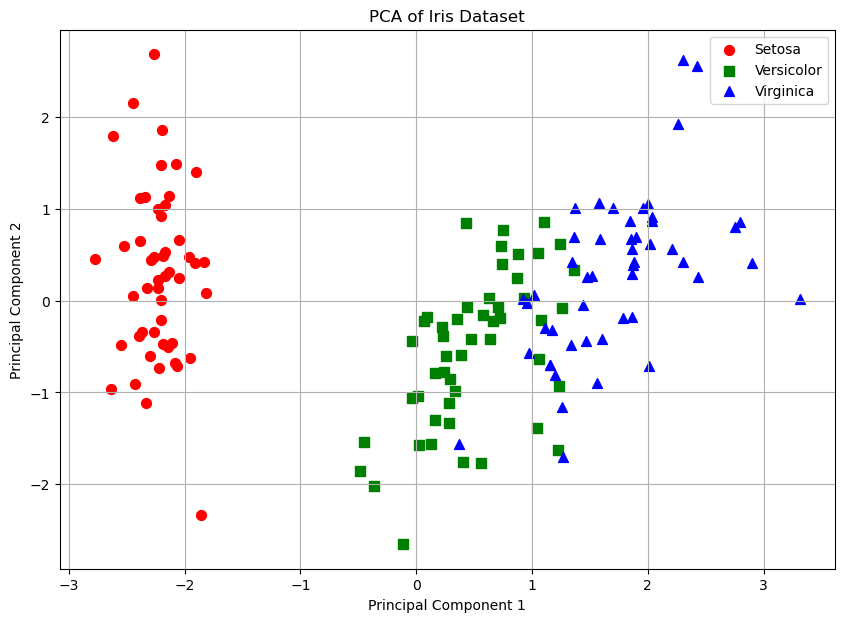

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Load some example data
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the data (important preprocessing step for PCA)
X_std = StandardScaler().fit_transform(X)

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA model to data and transform the data
X_pca = pca.fit_transform(X_std)

# Create a DataFrame for easier visualization
pca_df = pd.DataFrame(
    data=X_pca, 
    columns=['Principal Component 1', 'Principal Component 2']
)
pca_df['target'] = y

# Let's examine what the original features contribute to each principal component
# These are the "loadings" - how much each original feature contributes to each PC
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=iris.feature_names
)
print("Component loadings (how features contribute to PCs):")
print(loadings)

# Visualize the transformed data
plt.figure(figsize=(10, 7))
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']

for target, color, marker in zip(targets, colors, markers):
    indices_to_keep = pca_df['target'] == target
    plt.scatter(
        pca_df.loc[indices_to_keep, 'Principal Component 1'],
        pca_df.loc[indices_to_keep, 'Principal Component 2'],
        c=color, 
        marker=marker,
        s=50
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset')
plt.legend(['Setosa', 'Versicolor', 'Virginica'])
plt.grid(True)

Determining how many components to keep is a critical step. In this example, we will not limit the PCA to just 2 components. 

By default, scikit-learn will create as many components as there are features. 



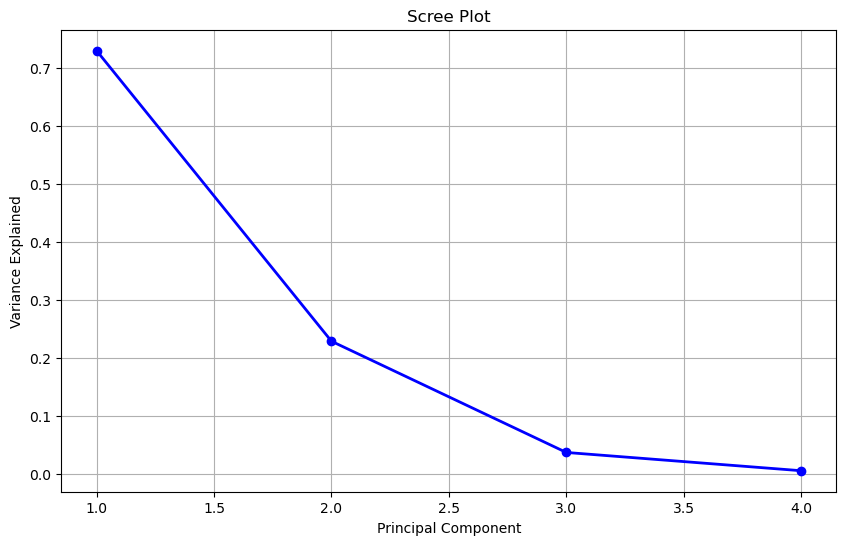

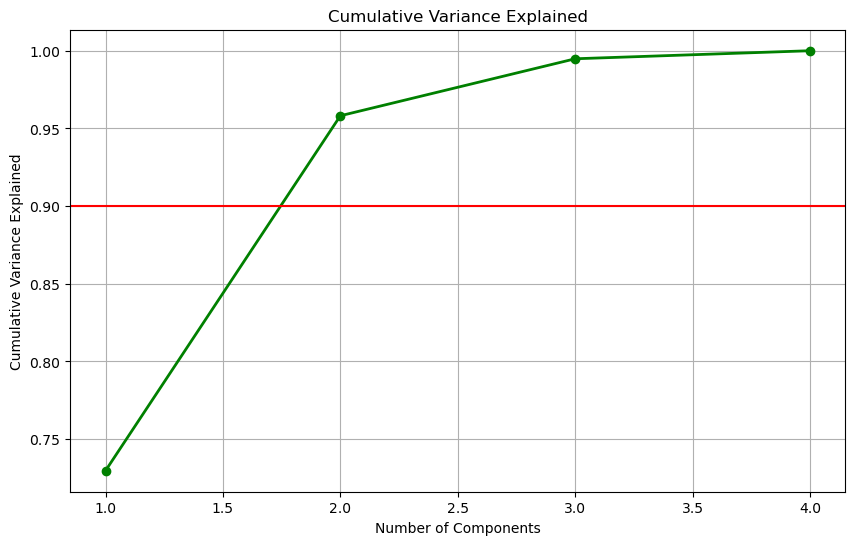

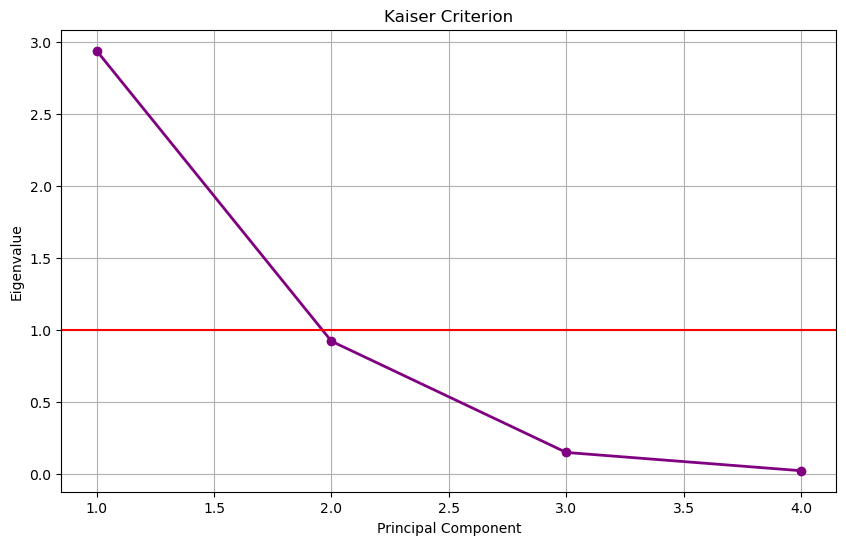

In [11]:
# Initialize PCA without restricting the number of components
pca_full = PCA()
pca_full.fit(X_std)

# Scree plot method
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)

# Cumulative variance explained method
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), 
         cumulative_variance, 'o-', linewidth=2, color='green')
plt.axhline(y=0.9, color='r', linestyle='-')  # 90% threshold line
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)

# Kaiser criterion method
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca_full.explained_variance_) + 1), 
         pca_full.explained_variance_, 'o-', linewidth=2, color='purple')
plt.axhline(y=1.0, color='r', linestyle='-')  # Eigenvalue = 1 line
plt.title('Kaiser Criterion')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)

This code and these visualizations demonstrate three approaches to component selection:

- Scree Plot Method: plots eigenvalues in descending order. We look for the "elbow" where the curve flattens, indicating diminishing returns from additional components.
- Cumulative Variance Explained: shows what percentage of total variance is captured as we add more components. We typically choose enough components to reach a threshold like 90% or 95%.
- Kaiser Criterion: suggests keeping only components with eigenvalues greater than 1.0, as these explain more variance than a single original variable would.

The optimal number of components differs by method and application. In our example, we might need only 2 components to explain 95% of variance in the Iris dataset, which reduces our data from 4 dimensions to 2 while preserving most information.

In [12]:
# Finding optimal number of components using different methods
# 1. Based on explained variance threshold (e.g., 95%)
target_variance = 0.95
n_components_variance = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components needed to explain {target_variance*100}% of variance: {n_components_variance}")

# 2. Based on Kaiser criterion (eigenvalues > 1)
n_components_kaiser = sum(pca_full.explained_variance_ > 1.0)
print(f"Number of components with eigenvalues > 1: {n_components_kaiser}")

# Let's use the determined number of components to transform our data
pca_optimal = PCA(n_components=n_components_variance)
X_pca_optimal = pca_optimal.fit_transform(X_std)
print(f"\nOriginal data shape: {X.shape}")
print(f"Reduced data shape: {X_pca_optimal.shape}")
print(f"Dimensionality reduction: {X.shape[1]} → {X_pca_optimal.shape[1]}")

Number of components needed to explain 95.0% of variance: 2
Number of components with eigenvalues > 1: 1

Original data shape: (150, 4)
Reduced data shape: (150, 2)
Dimensionality reduction: 4 → 2
